In [179]:
import numpy as np
import os.path
from numpy import pi, floor, sqrt
from math import pi as π
import scipy.sparse as sp
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import setup
from joblib import delayed, Parallel, parallel_backend

In [180]:
import importlib
importlib.reload(setup)

<module 'setup' from '/home/guillermo/Nextcloud/projects/Distributed_Q_gates_clean/Codes/setup.py'>

In [181]:
styles = ['science']
prefix = '../stylelib/'
sufix = '.mplstyle'
for i in range(len(styles)):
    styles[i] = prefix + styles[i] + sufix
plt.style.use(styles)
plt.rcParams.update({'font.size': 20})

# Comparison of times and Fig. 3

The task is to fix g and $\kappa$ and run our protocol for the different values of the time saved in the adiabtic files. Then compuete the fidelity and plot it against time in order to compare both protocols.

We try to avoid overflows in the definition of the wavefunction. Essentially
$$g(t) \propto \mathrm{sech}(\sigma t) = \frac{2}{e^{x}+e^{-x}} = \frac{2*e^{-x}}{1 + e^{-2x}},$$
with $x=|\sigma t|.$

## Evolution rutines 

In [147]:
from numpy import pi as π

def Trotter_solver_dynamics(time,v0,control,g1=None,g2=None):
    vt = [v0]
    last_t = time[0]
    for t in time[1:]:
        dt = t - last_t
        v0 = scipy.sparse.linalg.expm_multiply((-1j*dt) * control.Hamiltonian(g1=g1(t), g2=g2(t)), v0)
        vt.append(v0)
        last_t = t
    return np.array(vt).T

def Trotter_solver_dynamics_static(time,v0,H):
    
    vt = [v0]
            
    dt = time[1] - time[0]
    H = sp.csc_matrix(H)
    U = scipy.sparse.linalg.expm( -1j * dt * H )
    
    for t in time[1:]:
                
        v0 = U @ v0
        vt.append(v0)
        
    return np.array(vt).T

def gt(t, σ, κ):

    f = np.exp(-np.abs(σ*t))
    γ4 = 2*f/(1 + f*f)
        
    return σ*γ4

In [148]:
def state_transfer_times(lamb_shift=None, δ1=2*π*8.40701933547913, δ2=2*π*8.40701933547913,
                   ω1=2*π*8.40701933547913, ω2=2*π*8.40701933547913, g1=0, g2=0,
                    kappa=2*π*20e-3, κ1=None, κ2=None, σ=0.5,
                   duration=1000, Nt=3000, l=30, Nm=2101, Control_type = 'pulse_shaping', 
                   quiet=False, filename=None):
    if κ1 is None:
        κ1 = kappa
    if κ2 is None:
        κ2 = kappa
    if lamb_shift is None:
        lamb_shift = interp_lamb(κ1, lwv)

    
    control = setup.Exp2QB2Cavities(δLamb = lamb_shift, δ1 = δ1, δ2 = δ2, ω1 = ω1, ω2 = ω2, g1=0, g2=0, κ1=κ1, κ2=κ2, l=l, mmax=Nm)
    
    ## solve dynamics
    tdelay = 1*control.tprop #separation between protocol g_1(t) and g_2(t) /time reversed. 
    σ *= κ1
#     duration = tdelay + 2 * (Tfp/σ)times_1m
    time = np.linspace(-duration/2, duration/2, Nt)
    
    print(f'Type of control = ',Control_type)

    if Control_type == 'pulse_shaping':
   
        def g1t(t):
            return gt(t + tdelay/2, σ,  κ1)

        def g2t(t):
            return gt(tdelay/2 - t, σ,  κ2)

        #Control initial/final values:
        print(f'Initial value of the control g_1(-tf)= (2π)*{g1t(time[0])/2/π*1e3}MHz')

        vt = Trotter_solver_dynamics(time, control.qubit_excited(which=0), control, g1=g1t, g2=g2t)
        P = np.abs(vt)**2

    elif Control_type == 'STIRAP':
        
        def g1t(t): 
            return (κ1/5.625) * np.sin((t+duration/2)*π/(2*duration))

        def g2t(t):
            return (κ2/5.625) * np.cos((t+duration/2)*π/(2*duration))

        #Control initial/final values:
        print(f'Initial value of the control g_1(-tf)= (2π)*{g1t(time[0])/2/π*1e3}MHz')
        print(f'Initial value of the control g_2(-tf)= (2π)*{g2t(time[0])/2/π*1e3}MHz')


        vt = Trotter_solver_dynamics(time, control.qubit_excited(which=0), control, g1=g1t, g2=g2t)
        P = np.abs(vt)**2
        
    if Control_type == 'direct_swap':

        print(f'Initial value of the control g_1(-tf)= (2π)*{g1/2/π*1e3}MHz')
        
        
        vt = Trotter_solver_dynamics_static( time, control.qubit_excited(which=0), control.Hamiltonian(g1=g1, g2=g2) )      
        
        P = np.abs(vt)**2
        
        g1t = (lambda t: g1)
    
    
    ## Showing results:
    Pwaveguide = np.sum(P[4:,:],0)
    print(f'|q_1(tf)|^2 = {P[0,-1]}\n'
          f'|c_1(tf)|^2 = {P[2,-1]}\n'
          f'|wv(tf)|^2  = {Pwaveguide[-1]} (max = {max(Pwaveguide)})\n'
          f'|c_2(tf)|^2 = {P[3,-1]}\n'
          f'|q_2(tf)|^2 = {P[1,-1]}\n'
          f'|q_2max|^2 = {np.max(P[1,:])}\n'
          f' 1-F        = {1-P[1,-1]}')


    if not quiet:
        fig, (ax) = plt.subplots(nrows=1, figsize=(8,4), sharex=True)
        ax.plot(time*κ1, P[0,:], label='qubit 1')
        ax.plot(time*κ1, P[1,:], label='qubit 2')
        ax.plot(time*κ1, P[2,:], '--', label='cavity 1')
        ax.plot(time*κ1, P[3,:], '--', label='cavity 2')
        ax.plot(time*κ1, Pwaveguide, '-.', label='waveguide')
        #ax.set_xlabel(r'$t\κ1$')
        ax.legend(fontsize=16)

        fig.tight_layout()
        plt.show()
        
        if filename:
            fig.savefig(filename)
    
    timeres = time/control.tprop
    
    q1 = P[0,:]
    q2 = P[1,:]
    q1end = P[0,-1]
    q2end = P[1,-1]
    cav1end = P[2,-1]
    cav2end = P[3,-1]
    q1_max = np.max(P[0,:])
    q2_max = np.max(P[1,:])
    
        
    '''Compute how much time is spent in either qubit'''
    
    Time_max_fidelity = np.argmax(P[1,:])  # Time for which the population of the second qubit is maximal. This way it is valid for all three protocols 
    
    cumulative_time_qubit_1 = np.trapz(P[0,:Time_max_fidelity], x = time[:Time_max_fidelity])
    cumulative_time_qubit_2 = np.trapz(P[1,:Time_max_fidelity], x = time[:Time_max_fidelity])
    
    k = cumulative_time_qubit_1 + cumulative_time_qubit_2
    
    print(f'Time spent in either of the qubits ={k}*(ns)')
    
    duration_swap = time[np.argmax(P[1,:])]+duration/2
    
    print('Time spent to reach the maximum', time[np.argmax(P[1,:])]+duration/2)
    print(f'Total time ={duration}*(ns)')

    
    return q2end, q1end, max(Pwaveguide), cav1end, cav2end, control.ωrelevant, q1_max, q2_max, k, duration_swap, g1t(time[0])/2/π*1e3, q2

## Direct swap

We start with this protocol because it is the only one in wich we cannnot know the time in advance. We know from serafini et al. https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.96.010503 that the optimal tiem lies arouns $T \approx \pi / g $, however, the exact value has to be computed numerically.

$T protocol = 1 \mu s$ demands $g = 2 \pi \times 2 MHz = 2 \pi \times 2 *10^{-3} GHz$

In [149]:
κ = 2*π*90*1e-3

if os.path.exists('../Data/Direct_swap_1m_comparison_times.npy'):
    Direct_swap_1m_comparison_times = np.load('../Data/Direct_swap_1m_comparison_times.npy', allow_pickle = True)

else:
    
    times_1m_direct_swap = 1300/np.logspace(np.log10(0.03),np.log10(90),500)
    
    Direct_swap_1m_comparison_times = [state_transfer_times(δ1=2*π*8.492099722936853, δ2=2*π*8.492099722936853,
                                           ω1=2*π*8.492099722936853, ω2=2*π*8.492099722936853, g1=2*π*(1300/t)*1e-3, g2=2*π*(1300/t)*1e-3,
                                            lamb_shift=-0.01732777777777778*κ,
                                              kappa=κ, duration= t, Nt=1000 + np.int(1000/2), l=1, Nm=71, Control_type = 'direct_swap', quiet=True)
                                          for t in times_1m_direct_swap]

    Direct_swap_1m_comparison_times = np.array(Direct_swap_1m_comparison_times, dtype = object)
    
    # np.save('~/Data/Direct_swap_1m_comparison_times.npy', Direct_swap_1m_comparison_times)
    
    np.save(os.path.join('../Data', 'Direct_swap_1m_comparison_times.npy'), Direct_swap_1m_comparison_times)

In [150]:
κ = 2*π*18*1e-3

if os.path.exists('../Data/Direct_swap_5m_comparison_times.npy'):
    Direct_swap_5m_comparison_times = np.load('../Data/Direct_swap_5m_comparison_times.npy', allow_pickle = True)
    
else:
    
    times_5m_direct_swap = 1300 / np.logspace(np.log10(0.03),np.log10(18),72)
        
    Direct_swap_5m_comparison_times = [state_transfer_times(δ1=2*π*8.416408398466828, δ2=2*π*8.416408398466828,
                   ω1=2*π*8.416408398466828, ω2=2*π*8.416408398466828,  g1=2*π*(1300/t)*1e-3, g2=2*π*(1300/t)*1e-3,
                    lamb_shift=-0.011618999999999999*κ, 
                    kappa=κ, duration=t, Nt=1000 + np.int(t/2), l=5, Nm=351, Control_type = 'direct_swap', quiet=True)
                     for t in times_5m_direct_swap]
    
    Direct_swap_5m_comparison_times = np.array(Direct_swap_5m_comparison_times, dtype = object)
    
    np.save('../Data/Direct_swap_5m_comparison_times', Direct_swap_5m_comparison_times)

In [151]:
κ = 2*π*3*1e-3

if os.path.exists('../Data/Direct_swap_30m_comparison_times.npy'):
    Direct_swap_30m_comparison_times = np.load('../Data/Direct_swap_30m_comparison_times.npy', allow_pickle = True)
else:
    times_30m_direct_swap = 1300 / np.logspace(np.log10(0.01),np.log10(6),72)

    with parallel_backend('loky', n_jobs=36):
       
        Direct_swap_30m_comparison_times = Parallel()(delayed(state_transfer_times)(δ1=2*π*8.40701933547913, δ2=2*π*8.40701933547913,
                       ω1=2*π*8.40701933547913, ω2=2*π*8.40701933547913,  g1=2*π*(1300/t)*1e-3, g2=2*π*(1300/t)*1e-3,
                        lamb_shift=-0.012187088888888885*κ, 
                        kappa=κ, duration=t, Nt=1000 + np.int(t/2), l=30, Nm=701, Control_type = 'direct_swap', quiet=True)
                         for t in times_30m_direct_swap)

        Direct_swap_30m_comparison_times = np.array(Direct_swap_30m_comparison_times, dtype = object)

        np.save('../Data/Direct_swap_30m_comparison_times', Direct_swap_30m_comparison_times)

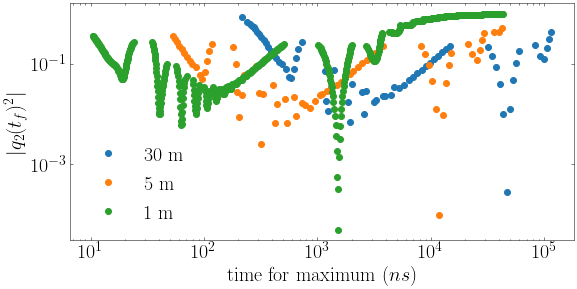

In [152]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8,4), sharey = True, constrained_layout=True)

ax1.loglog(Direct_swap_30m_comparison_times[:,9], 1-Direct_swap_30m_comparison_times[:,7],'o', label =' 30 m' )
ax1.loglog(Direct_swap_5m_comparison_times[:,9], 1-Direct_swap_5m_comparison_times[:,7],'o', label =' 5 m' )
ax1.loglog(Direct_swap_1m_comparison_times[:,9], 1-Direct_swap_1m_comparison_times[:,7],'o', label =' 1 m' )


ax1.set_ylabel('$$|q_2(t_f)^2|$$')
ax1.set_xlabel('time for maximum $(ns) $ ')


ax1.legend()
plt.show()

## Pulse shaping

In [153]:
# 1 meter WG.

if os.path.exists('../Data/pulse_shaping_1m_comparison_times.npy'):
    pulse_shaping_1m_comparison_times = np.load('../Data/pulse_shaping_1m_comparison_times.npy', allow_pickle = True)
    
else:
    
    κ = 2*π*90*1e-3
    times_1m = 1300 / np.logspace(np.log10(0.05),np.log10(90),72)
    
    with parallel_backend('loky', n_jobs=36):
       
        pulse_shaping_1m_comparison_times = Parallel()(delayed(state_transfer_times)(δ1=2*π*8.492099722936853, δ2=2*π*8.492099722936853,
                   ω1=2*π*8.492099722936853, ω2=2*π*8.492099722936853, lamb_shift=-0.01732777777777778*κ,
                                                      kappa=κ, duration=t, Nt=1000 + np.int(t/2), l=1, Nm=71, quiet=True)
                     for t in times_1m)

        pulse_shaping_1m_comparison_times = np.array(pulse_shaping_1m_comparison_times, dtype = object)

        np.save('../Data/pulse_shaping_1m_comparison_times.npy', pulse_shaping_1m_comparison_times)

In [154]:
# 5 meter WG.

if os.path.exists('../Data/pulse_shaping_5m_comparison_times.npy'):
    pulse_shaping_5m_comparison_times = np.load('../Data/pulse_shaping_5m_comparison_times.npy', allow_pickle = True)
    
else:
    
    κ = 2*π*18*1e-3
    times_5m = 1300 / np.logspace(np.log10(0.05),np.log10(18),36)
    
    with parallel_backend('loky', n_jobs=18):
       
        pulse_shaping_5m_comparison_times = Parallel()(delayed(state_transfer_times)(δ1=2*π*8.416408398466828, δ2=2*π*8.416408398466828,
                   ω1=2*π*8.416408398466828, ω2=2*π*8.416408398466828, lamb_shift=-0.012187088888888885*κ, kappa=κ, duration=t, Nt=1000 + np.int(t/2), l=5, Nm=351, quiet=True)
                     for t in times_5m)

        pulse_shaping_5m_comparison_times = np.array(pulse_shaping_5m_comparison_times, dtype = object)

        np.save('../Data/pulse_shaping_5m_comparison_times.npy', pulse_shaping_5m_comparison_times)

In [155]:
# 30 meter WG.

if os.path.exists('../Data/pulse_shaping_30m_comparison_times.npy'):
    pulse_shaping_30m_comparison_times = np.load('../Data/pulse_shaping_30m_comparison_times.npy', allow_pickle = True)
    
else:
        κ = 2*π*3*1e-3
        times_30m = 1300 / np.logspace(np.log10(0.05),np.log10(4),18)

#     with parallel_backend('loky', n_jobs=18):
       
#         pulse_shaping_30m_comparison_times = Parallel()(delayed(state_transfer_times)(lamb_shift=-0.011618999999999999*κ, kappa=κ,
#                                                                     duration=t, Nt=1000 + np.int(t/5), quiet=True) for t in times_30m)
        
        pulse_shaping_30m_comparison_times = [state_transfer_times(lamb_shift=-0.011618999999999999*κ, kappa=κ,
                                                                duration=t, Nt=1000 + np.int(t/5), quiet=True) for t in time_30m]

        pulse_shaping_30m_comparison_times = np.array(pulse_shaping_30m_comparison_times, dtype=object)

        np.save('../Data/pulse_shaping_30m_comparison_times.npy', pulse_shaping_30m_comparison_times)

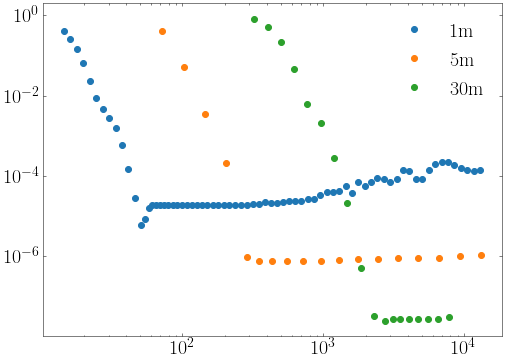

In [156]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(7,5), sharey = True, constrained_layout=True)

ax1.loglog(pulse_shaping_1m_comparison_times[:,9], 1-pulse_shaping_1m_comparison_times[:,0],'o', label = '1m')
ax1.loglog(pulse_shaping_5m_comparison_times[:,9], 1-pulse_shaping_5m_comparison_times[:,0],'o', label = '5m')
ax1.loglog(pulse_shaping_30m_comparison_times[:,9], 1-pulse_shaping_30m_comparison_times[:,0],'o', label = '30m')


ax1.legend()

plt.show()

## STIRAP 

Contrary to our method, which we have demonstrated to work for every regime of operation, the maximum g (which determines to some extent the duration of the protocol), for the adiabatic protocol is determined by how far apart are the resonant and the two closest hibrid cavity-WG modes.

It turns out that this condition is a lot more restrictive to how big can it be than the $g_{\text{max}} = \kappa/2$ required for pulse shaping. 

Mimicking the article of cleland https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.124.240502 and citing the appropriate sources we impose the condition $ g_{\text{max}} = \kappa/5.26 $. This is key for $g$ being such that the spacing between $\tilde{\omega}_0$ and $\tilde{\omega}_{\pm}$ which is proportional to $G$. $\tilde{\omega}_{\pm} =\tilde{\omega}_0 \pm \sqrt{2}G $. Recall that $G \propto \sqrt{\frac{\kappa}{l} }$.

In [157]:
κ = 2*π*90*1e-3

times_1m = 1300/np.logspace(np.log10(0.05),np.log10(70),72)

if os.path.exists('../Data/STIRAP_1m_comparison_times.npy'):
    
    STIRAP_1m_comparison_times = np.load('../Data/STIRAP_1m_comparison_times.npy', allow_pickle = True)

else:
    with parallel_backend('loky', n_jobs=36):
       
        STIRAP_1m_comparison_times = Parallel()(delayed(state_transfer_times)(δ1=2*π*8.492099722936853, δ2=2*π*8.492099722936853,
                                           ω1=2*π*8.492099722936853, ω2=2*π*8.492099722936853,
                                            lamb_shift=-0.01732777777777778*κ,
                                              kappa=κ, duration= t, Nt=1000 + np.int(t), l=1, Nm=71, Control_type = 'STIRAP', quiet=True)
                                          for t in times_1m)

    STIRAP_1m_comparison_times = np.array(STIRAP_1m_comparison_times, dtype = object)
    
    np.save('../Data/STIRAP_1m_comparison_times.npy', STIRAP_1m_comparison_times)

In [158]:
κ = 2*π*18*1e-3

times_5m = 1300/np.logspace(np.log10(0.02),np.log10(18),72)

if os.path.exists('../Data/STIRAP_5m_comparison_times.npy'):
    STIRAP_5m_comparison_times = np.load('../Data/STIRAP_5m_comparison_times.npy', allow_pickle = True)
    
else:
    
    with parallel_backend('loky', n_jobs=36):
    
        STIRAP_5m_comparison_times = Parallel()(delayed(state_transfer_times)(δ1=2*π*8.416408398466828, δ2=2*π*8.416408398466828,
                   ω1=2*π*8.416408398466828, ω2=2*π*8.416408398466828, lamb_shift=-0.012187088888888885*κ, kappa=κ, duration=t,
                   Nt=1000 + np.int(t/2), l=5, Nm=351, Control_type = 'STIRAP', quiet=True)
                     for t in times_5m)
    
    STIRAP_5m_comparison_times = np.array(STIRAP_5m_comparison_times, dtype = object)
    
    np.save('../Data/STIRAP_5m_comparison_times.npy', STIRAP_5m_comparison_times)

In [159]:
κ = 2*π*3*1e-3

times_30m = 1300/np.logspace(np.log10(0.01),np.log10(5),36)

if os.path.exists('../Data/STIRAP_30m_comparison_times.npy'):
    STIRAP_30m_comparison_times = np.load('../Data/STIRAP_30m_comparison_times.npy', allow_pickle = True)
    
else:
    
    with parallel_backend('loky', n_jobs=36):

        STIRAP_30m_comparison_times = Parallel()(delayed(state_transfer_times)(lamb_shift=-0.011618999999999999*κ, kappa=κ, duration=t,
                    Nt=1000 + np.int(t/2), l=30, Nm=500, Control_type = 'STIRAP', quiet=True)
                     for t in times_30m)
        

    
    STIRAP_30m_comparison_times = np.array(STIRAP_30m_comparison_times, dtype = object)
    
    np.save('../Data/STIRAP_30m_comparison_times.npy', STIRAP_30m_comparison_times)

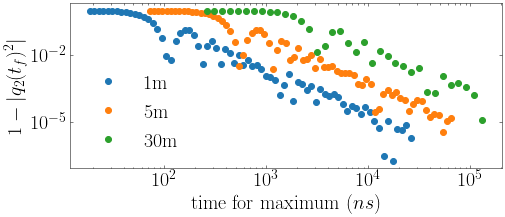

In [160]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(7,3), sharey = True, constrained_layout=True)

ax1.loglog(times_1m, 1-STIRAP_1m_comparison_times[:,0],'o', label = '1m')
ax1.loglog(STIRAP_5m_comparison_times[:,9], 1-STIRAP_5m_comparison_times[:,0],'o', label = '5m')
ax1.loglog(STIRAP_30m_comparison_times[:,9], 1-STIRAP_30m_comparison_times[:,0],'o', label = '30m')
ax1.set_ylabel('$$1- |q_2(t_f)^2|$$')
ax1.set_xlabel('time for maximum $(ns) $ ')


ax1.legend()

plt.show()

## Comparison of protocols 

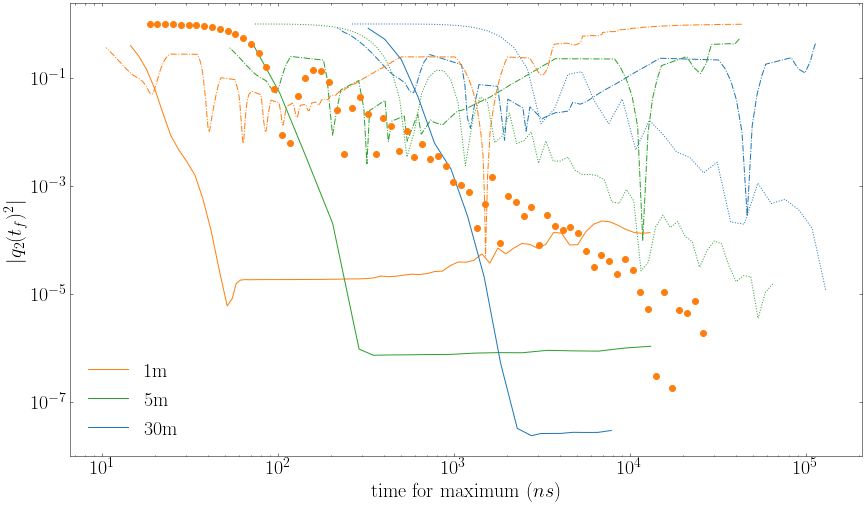

In [161]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(12,7), sharey = True, constrained_layout=True)

ax1.loglog(Direct_swap_30m_comparison_times[:,9], 1-Direct_swap_30m_comparison_times[:,7],'-.', color='tab:blue')
ax1.loglog(Direct_swap_5m_comparison_times[:,9], 1-Direct_swap_5m_comparison_times[:,7],'-.', color='tab:green')
ax1.loglog(Direct_swap_1m_comparison_times[:,9], 1-Direct_swap_1m_comparison_times[:,7],'-.', color='tab:orange')

ax1.loglog(pulse_shaping_1m_comparison_times[:,9], 1-pulse_shaping_1m_comparison_times[:,0],'-', color='tab:orange', label = '1m')
ax1.loglog(pulse_shaping_5m_comparison_times[:,9], 1-pulse_shaping_5m_comparison_times[:,0],'-',color='tab:green', label = '5m')
ax1.loglog(pulse_shaping_30m_comparison_times[:,9], 1-pulse_shaping_30m_comparison_times[:,0],'-', color='tab:blue', label = '30m')

ax1.loglog(STIRAP_1m_comparison_times[:,9], 1-STIRAP_1m_comparison_times[:,0],'o', color='tab:orange')
ax1.loglog(STIRAP_5m_comparison_times[:,9], 1-STIRAP_5m_comparison_times[:,0],':', color='tab:green')
ax1.loglog(STIRAP_30m_comparison_times[:,9], 1-STIRAP_30m_comparison_times[:,0],':', color='tab:blue')


ax1.set_ylabel('$$|q_2(t_f)^2|$$')
ax1.set_xlabel('time for maximum $(ns) $ ')


ax1.legend()
plt.show()

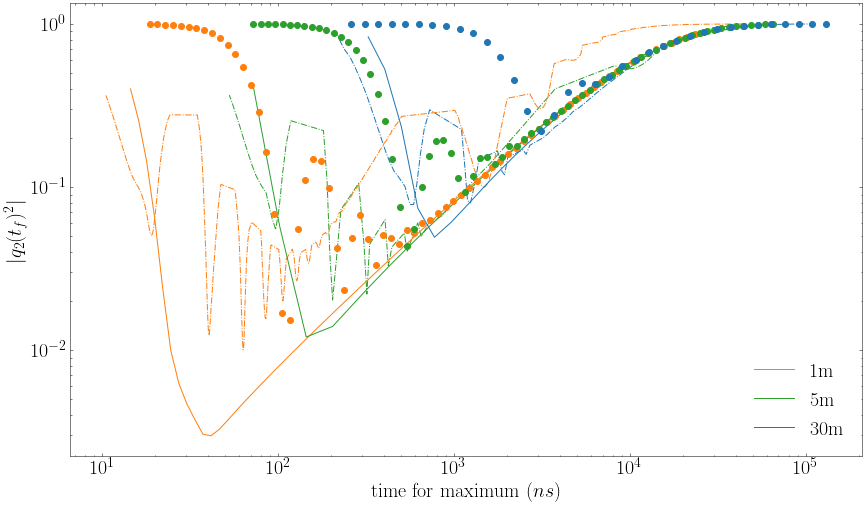

In [162]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(12,7), sharey = True, constrained_layout=True)

T1_1=11.5e-6*1e9


ax1.loglog(Direct_swap_30m_comparison_times[:,9], 1-Direct_swap_30m_comparison_times[:,7]*np.exp(-np.array(Direct_swap_30m_comparison_times[:,8], dtype = float)/T1_1),'-.', color='tab:blue')
ax1.loglog(Direct_swap_5m_comparison_times[:,9], 1-Direct_swap_5m_comparison_times[:,7]*np.exp(-np.array(Direct_swap_5m_comparison_times[:,8], dtype = float)/T1_1),'-.', color='tab:green')
ax1.loglog(Direct_swap_1m_comparison_times[:,9], 1-Direct_swap_1m_comparison_times[:,7]*np.exp(-np.array(Direct_swap_1m_comparison_times[:,8], dtype = float)/T1_1),'-.', color='tab:orange')

ax1.loglog(pulse_shaping_1m_comparison_times[:,9], 1-pulse_shaping_1m_comparison_times[:,0]*np.exp(-np.array(pulse_shaping_1m_comparison_times[:,8], dtype = float)/T1_1),'-', color='tab:orange', label = '1m')
ax1.loglog(pulse_shaping_5m_comparison_times[:,9], 1-pulse_shaping_5m_comparison_times[:,0]*np.exp(-np.array(pulse_shaping_5m_comparison_times[:,8], dtype = float)/T1_1),'-',color='tab:green', label = '5m')
ax1.loglog(pulse_shaping_30m_comparison_times[:,9], 1-pulse_shaping_30m_comparison_times[:,0]*np.exp(-np.array(pulse_shaping_30m_comparison_times[:,8], dtype = float)/T1_1),'-', color='tab:blue', label = '30m')

ax1.loglog(STIRAP_1m_comparison_times[:,9], 1-STIRAP_1m_comparison_times[:,0]*np.exp(-np.array(STIRAP_1m_comparison_times[:,8], dtype = float)/T1_1),'o', color='tab:orange')
ax1.loglog(STIRAP_5m_comparison_times[:,9], 1-STIRAP_5m_comparison_times[:,0]*np.exp(-np.array(STIRAP_5m_comparison_times[:,8], dtype = float)/T1_1),'o', color='tab:green')
ax1.loglog(STIRAP_30m_comparison_times[:,9], 1-STIRAP_30m_comparison_times[:,0]*np.exp(-np.array(STIRAP_30m_comparison_times[:,8], dtype = float)/T1_1),'o', color='tab:blue')


ax1.set_ylabel('$$|q_2(t_f)^2|$$')
ax1.set_xlabel('time for maximum $(ns) $ ')


ax1.legend()
plt.show()

## Fidelity Vs Cut-off

In [163]:
κ = 2*π*3*1e-3
σ = 0.5*κ
t = np.linspace(-1650,-5,20)
# t = np.logspace(-70,-1,20)
gt(t, σ, κ)/2/π*1e3, times_30m[0]

(array([5.29003205e-07, 1.19629175e-06, 2.70530300e-06, 6.11779218e-06,
        1.38348204e-05, 3.12861650e-05, 7.07507644e-05, 1.59996301e-04,
        3.61816811e-04, 8.18215159e-04, 1.85031723e-03, 4.18431450e-03,
        9.46236398e-03, 2.13973840e-02, 4.83780768e-02, 1.09285593e-01,
        2.45795568e-01, 5.40807174e-01, 1.07435539e+00, 1.49833604e+00]),
 130000.0)

In [164]:
# 1 meter WG.

if os.path.exists('../Data/pulse_shaping_1m_cutoff.npy'):
    pulse_shaping_1m_cutoff = np.load('../Data/pulse_shaping_1m_cutoff.npy', allow_pickle = True)
    
else:
    
    κ = 2*π*90*1e-3
    times_1m = np.linspace(140,20,30)
    
    with parallel_backend('loky', n_jobs=36):
       
        pulse_shaping_1m_cutoff = Parallel()(delayed(state_transfer_times)(δ1=2*π*8.492099722936853, δ2=2*π*8.492099722936853,
                   ω1=2*π*8.492099722936853, ω2=2*π*8.492099722936853, lamb_shift=-0.01732777777777778*κ,
                                                      kappa=κ, duration=t, Nt=1000 + np.int(t/2), l=1, Nm=71, quiet=True)
                     for t in times_1m)

        pulse_shaping_1m_cutoff = np.array(pulse_shaping_1m_cutoff, dtype = object)

        np.save('../Data/pulse_shaping_1m_cutoff.npy', pulse_shaping_1m_cutoff)

In [165]:
# 5 meter WG.

if os.path.exists('../Data/pulse_shaping_5m_cutoff.npy'):
    pulse_shaping_5m_cutoff = np.load('../Data/pulse_shaping_5m_cutoff.npy', allow_pickle = True)
    
else:
    
    κ = 2*π*18*1e-3
    times_5m = np.linspace(640,20,30)
    
    with parallel_backend('loky', n_jobs=18):
       
        pulse_shaping_5m_cutoff = Parallel()(delayed(state_transfer_times)(δ1=2*π*8.416408398466828, δ2=2*π*8.416408398466828,
                   ω1=2*π*8.416408398466828, ω2=2*π*8.416408398466828, lamb_shift=-0.012187088888888885*κ, kappa=κ, duration=t, Nt=1000 + np.int(t/2), l=5, Nm=351, quiet=True)
                     for t in times_5m)

        pulse_shaping_5m_cutoff = np.array(pulse_shaping_5m_cutoff, dtype = object)

        np.save('../Data/pulse_shaping_5m_cutoff.npy', pulse_shaping_5m_cutoff)

In [166]:
# 30 meter WG.

if os.path.exists('../Data/pulse_shaping_30m_cutoff.npy'):
    pulse_shaping_30m_cutoff = np.load('../Data/pulse_shaping_30m_cutoff.npy', allow_pickle = True)
    
else:
        κ = 2*π*3*1e-3
        times_30m = np.linspace(3470,10,30)

        with parallel_backend('loky', n_jobs=18):
       
            pulse_shaping_30m_cutoff = Parallel()(delayed(state_transfer_times)(lamb_shift=-0.011618999999999999*κ, kappa=κ,
                                                                    duration=t, Nt=1000 + np.int(t/5), quiet=True) for t in times_30m)
        
        # pulse_shaping_30m_cutoff = [state_transfer_times(lamb_shift=-0.011618999999999999*κ, kappa=κ,
        #                                                         duration=t, Nt=1000 + np.int(t/5), quiet=True) for t in time_30m]

        pulse_shaping_30m_cutoff = np.array(pulse_shaping_30m_cutoff, dtype=object)

        np.save('../Data/pulse_shaping_30m_cutoff.npy', pulse_shaping_30m_cutoff)

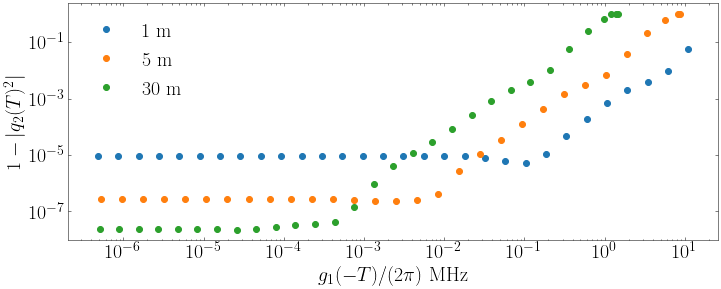

(4.796917544956339e-07, 5.286185009209076e-07, 5.044117810780252e-07)

In [167]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey = True, constrained_layout=True)

ax1.loglog(pulse_shaping_1m_cutoff[:,10], 1-pulse_shaping_1m_cutoff[:,7],'o', label =' 1 m' )
ax1.loglog(pulse_shaping_5m_cutoff[:,10], 1-pulse_shaping_5m_cutoff[:,7],'o', label =' 5 m' )
ax1.loglog(pulse_shaping_30m_cutoff[:,10], 1-pulse_shaping_30m_cutoff[:,7],'o', label =' 30 m' )

ax1.set_ylabel('$1 - |q_2(T)^2|$')
ax1.set_xlabel('$g_1(-T)$/$(2 \pi)$ MHz ')


ax1.legend()
plt.show()
pulse_shaping_1m_cutoff[:,10][0], pulse_shaping_5m_cutoff[:,10][0],  pulse_shaping_30m_cutoff[:,10][0]

## Robustness against time-variations.

The idea of this section is to establish a quantitative measure of how robust is the protocol against time variations. For that, we are going to take the optimal points of each of the three (when considering the $T=11.5\mu s$), and, leaving the g fixed, do sweep over times.

In [168]:
'''We define the variables that contain the optimal values for each of the protocols 
for 1m WG and the T1 of 11.5 μs. First component: value. Second component: entry of the vector.'''

Optimal_swap = [np.min(1-Direct_swap_1m_comparison_times[:,7]    *  np.exp(-np.array(Direct_swap_1m_comparison_times[:,8], dtype = float)/T1_1)), np.argmin(1-Direct_swap_1m_comparison_times[:,7]    *  np.exp(-np.array(Direct_swap_1m_comparison_times[:,8], dtype = float)/T1_1))]
Optimal_shaping = [np.min(1-pulse_shaping_1m_comparison_times[:,0]  *  np.exp(-np.array(pulse_shaping_1m_comparison_times[:,8], dtype = float)/T1_1)), np.argmin(1-pulse_shaping_1m_comparison_times[:,0]  *  np.exp(-np.array(pulse_shaping_1m_comparison_times[:,8], dtype = float)/T1_1))]
Optimal_STIRAP = [np.min(1-STIRAP_1m_comparison_times[:,0]         *  np.exp(-np.array(STIRAP_1m_comparison_times[:,8], dtype = float)/T1_1)), np.argmin(1-STIRAP_1m_comparison_times[:,0]         *  np.exp(-np.array(STIRAP_1m_comparison_times[:,8], dtype = float)/T1_1))]

In [169]:
'''We define the variables that contain the optimal values for each of the protocols .'''

# Optimal_swap = [np.min(1-Direct_swap_1m_comparison_times[:,7]), np.argmin(1-Direct_swap_1m_comparison_times[:,7])]
# Optimal_shaping = [np.min(1-pulse_shaping_1m_comparison_times[:,0]), np.argmin(1-pulse_shaping_1m_comparison_times[:,0])]
# Optimal_STIRAP = [np.min(1-STIRAP_1m_comparison_times[:,0]), np.argmin(1-STIRAP_1m_comparison_times[:,0])]

'We define the variables that contain the optimal values for each of the protocols .'

In [170]:
Optimal_swap

[0.010059395811477745, 365]

In [171]:
''' We obtain the protocol time that lead to such optimal values '''

Time_Optimal_shaping = pulse_shaping_1m_comparison_times[:,9][Optimal_shaping[1]]
Time_Optimal_swap = Direct_swap_1m_comparison_times[:,9][Optimal_swap[1]]
Time_Optimal_STIRAP = STIRAP_1m_comparison_times[:,9][Optimal_STIRAP[1]]

In [172]:
Time_Optimal_shaping, Time_Optimal_swap, Time_Optimal_STIRAP, 

(41.51355523450823, 63.11894280794738, 116.43017769676511)

In [176]:
times_1m_direct_swap = 1300/np.logspace(np.log10(0.03),np.log10(90),500)
Enough_duration = times_1m_direct_swap[330]
Enough_duration

217.43180513645885

In [177]:
'''CHANGE TO THE POINT AROUND 100 NS  '''
κ = 2*π*90*1e-3

Robustness_Direct_swap_1m = state_transfer_times(δ1=2*π*8.492099722936853, δ2=2*π*8.492099722936853,
                                           ω1=2*π*8.492099722936853, ω2=2*π*8.492099722936853, g1=2*π*(1300/Time_Optimal_swap)*1e-3, g2=2*π*(1300/Time_Optimal_swap)*1e-3,
                                            lamb_shift=-0.01732777777777778*κ,
                                              kappa=κ, duration= Enough_duration/2, Nt=1000 + np.int(1000/2), l=1, Nm=71, Control_type = 'direct_swap', quiet=True)

Robustness_pulse_shaping_1m = state_transfer_times(δ1=2*π*8.492099722936853, δ2=2*π*8.492099722936853,
                                           ω1=2*π*8.492099722936853, ω2=2*π*8.492099722936853, g1=2*π*(1300/Time_Optimal_swap)*1e-3, g2=2*π*(1300/Time_Optimal_swap)*1e-3,
                                            lamb_shift=-0.01732777777777778*κ,
                                              kappa=κ, duration= Enough_duration/2, Nt=1000 + np.int(1000/2), l=1, Nm=71, Control_type = 'pulse_shaping', quiet=True)

Robustness_STIRAP_1m = state_transfer_times(δ1=2*π*8.492099722936853, δ2=2*π*8.492099722936853,
                                           ω1=2*π*8.492099722936853, ω2=2*π*8.492099722936853, g1=2*π*(1300/Time_Optimal_swap)*1e-3, g2=2*π*(1300/Time_Optimal_swap)*1e-3,
                                            lamb_shift=-0.01732777777777778*κ,
                                              kappa=κ, duration= Enough_duration/2, Nt=1000 + np.int(1000/2), l=1, Nm=71, Control_type = 'STIRAP', quiet=True)

Type of control =  direct_swap
Initial value of the control g_1(-tf)= (2π)*20.596035709208927MHz
|q_1(tf)|^2 = 0.039649689736450014
|c_1(tf)|^2 = 0.09799532767952096
|wv(tf)|^2  = 0.3942753139667332 (max = 0.42800320725877433)
|c_2(tf)|^2 = 0.15816884994397715
|q_2(tf)|^2 = 0.3099108186733193
|q_2max|^2 = 0.9516317234727311
 1-F        = 0.6900891813266807
Time spent in either of the qubits =61.54262924997334*(ns)
Time spent to reach the maximum 98.27221346227543
Total time =108.71590256822942*(ns)
Type of control =  pulse_shaping
Initial value of the control g_1(-tf)= (2π)*3.99677756410748e-05MHz
|q_1(tf)|^2 = 1.4075869623398044e-07
|c_1(tf)|^2 = 1.039093335531488e-06
|wv(tf)|^2  = 9.665421590606331e-06 (max = 0.6297745297887466)
|c_2(tf)|^2 = 7.660507249075066e-06
|q_2(tf)|^2 = 0.9999814942189816
|q_2max|^2 = 0.9999909102406738
 1-F        = 1.8505781018363088e-05
Time spent in either of the qubits =71.22234328386804*(ns)
Time spent to reach the maximum 80.06828314564729
Total time =

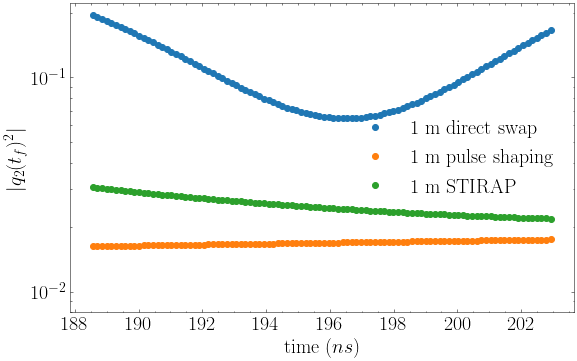

In [195]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8,5), sharey = True, constrained_layout=True)

time = np.linspace(0, Enough_duration, 1500)

# ax1.plot(time,Robustness_Direct_swap_1m[11][1100:1250],'o', label =' 1 m' )
# ax1.plot(time,Robustness_pulse_shaping_1m[11][1100:1250],'o', label =' 1 m' )
# ax1.plot(time,Robustness_STIRAP_1m[11][1100:1250],'o', label =' 1 m' )

ax1.semilogy(time[1300:1400],1-Robustness_Direct_swap_1m[11][1300:1400] * np.exp(-np.array(time[1300:1400], dtype = float)/T1_1),'o', label =' 1 m direct swap' )
ax1.semilogy(time[1300:1400],1-Robustness_pulse_shaping_1m[11][1300:1400]* np.exp(-np.array(time[1300:1400], dtype = float)/T1_1),'o', label =' 1 m pulse shaping' )
ax1.semilogy(time[1300:1400],1-Robustness_STIRAP_1m[11][1300:1400]* np.exp(-np.array(time[1300:1400], dtype = float)/T1_1),'o', label =' 1 m STIRAP' )

ax1.set_ylim(.8e-2)



ax1.set_ylabel('$$|q_2(t_f)^2|$$')
ax1.set_xlabel('time $(ns) $ ')


ax1.legend()
plt.show()

In [ ]:
20